## reaction diffusion simulations

In [1]:
import numpy as np
import pandas as pd
import uuid

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

### define particles and trajectory classes
only property of particle-types is diffusion and a geometry object

**to clean up**
particle types contain their uni-molecular reactions but this should be separated to mirror the case of bi-molecular reactions. i.e define inducts (uni and bi-), each induc class has a method to get their instances in the simulation.
traj has uni- and b- reactors, that call the method, loop over the reactions associated with the inducts, and effects them

In [2]:
class ptype:
    """basic particle type, with name and physical properties
    it also has a list of unimolecular reactions A -> products
    """
    def __init__(self,diffusion,name,geometry):
        self.diffusion=diffusion
        self.name=name
        self.unimolecular_reactions = []
        self.unimolecular_probs = []
        self.geometry= geometry
        
    def add_reaction(self,reaction):
        """adds a unimolecular_reaction to the list for this particle type
        and updates the probabilities function"""
        (self.unimolecular_reactions).append(reaction)
        rates = np.array([rea.rate for rea in self.unimolecular_reactions])
        self.unimolecular_probs = rates
        
    def choose_reaction(self,dt):
        """chooses one reaction (or none) for a given time step
        that reaction can then be effected on a particle with effect_reaction
        """
        if len(self.unimolecular_probs)==0:
            return None
        else:
            rates = self.unimolecular_probs
            probs = (rates/rates.sum())*(1 - np.exp( - dt* rates.sum()))
            #print("Cumulative probs: ",np.cumsum(probs))
            alpha=np.random.uniform(size=1)
            conf = np.cumsum(probs)>alpha
            if any(conf):
                ii = np.argmax(conf)
                #print("Chosen rection %s" % self.unimolecular_reactions[ii].name)
                return self.unimolecular_reactions[ii]
            else:
                return None
        

class geometry(object):
    """a basic basic geometry specification
    ideally it would include boundary conditions, dimensionality
    external potentials, etc. 
    It's used to evolve the dynamics of particles, 
    so each particle type is attached to a geometry object at construction
    """
    def __init__(self, size, dim=2):
        self.dim=dim
        self.size=size
        self.bc='pbc'
        
        
        
class particle:
    """particle instance, it has an id, position, age, types, etc."""
    def __init__(self, ptype, pos, age = 0, id = None ):
        if id==None:
            self.id = uuid.uuid4()
        else:
            self.id = id
        self.ptype = ptype
        self.age = age
        self.pos = pos
        
    def step(self,dt):
        pos1 = self.pos + np.sqrt(2*self.ptype.diffusion*dt)*np.random.normal(0, 1, 2)
        if(self.ptype.geometry.bc == 'pbc'):
            box = self.ptype.geometry.size
            pos1=pos1 - np.floor(pos1/box) * box
        #print("type %s, age %d"% (self.ptype.name, self.age))
        pnew = particle(self.ptype, pos1,
                        age = self.age + 1, id = self.id)
        return pnew

        
class traj:
    """a traj is a list (frames) of lists of particles"""
    
    def __init__(self, particles=[]):
        self.ptraj = []
        self.nframes = 0
        (self.ptraj).append(particles)

    def __getitem__(self, key):
        if isinstance(key, slice):
            print("sliced trajectory")
        outt = traj()
        outt.ptraj=self.ptraj[key]
        outt.nframes = len(outt.ptraj)
        return outt
        
    def describe(self):
        n = len(self.ptraj)
        print("Length %d (%d)" % (n,self.nframes))
        
    def step(self,dt):
        newvals=[]
        for pa in (self.ptraj)[self.nframes]:
            pa1 = pa.step(dt)
            newvals.append(pa1)
        (self.ptraj).append(newvals)
        self.nframes = (self.nframes)+1

    def react_unimolecular(self, dt):
        ###### unimolecular reactions would be defined 
        ###### on unm_inducts to mimick other orders
        ###### then here we can pass the set of unim_inducts 
        """loops over particles and reacts them with their unimolecular reactions
         unimolecular reactions are associated to the incoming pair
        """
        newvals=[]
        for pa in (self.ptraj)[self.nframes]:
            react = pa.ptype.choose_reaction(dt)
            if(not react==None):
                pa1 = react.effect_reaction(pa)
                if not pa1==None:
                    for pa11 in pa1:
                        newvals.append(pa11)
            else:
                newvals.append(pa)
        
        (self.ptraj)[self.nframes] = newvals
        
    def react_bimolecular(self, dt, bim_inducts, verbose=False):
        """ bimolecular reactions        
        """
        frame = (self.ptraj)[self.nframes]
        if verbose:
            print("reacting frame %d" % self.nframes)
        #loop over inducts, get instances, choose reaction, effect reaction
        # remember to add the particles that are not in any instance
        for induct in bim_inducts:
            #print("induct name: %s"%induct.name)
            induct_instances = induct.get_ec(frame)
            ##if len(induct_instances)>0:
            ##    print(induct_instances)
            for EC_instance in induct_instances:
                react = induct.choose_reaction(dt)
                if(not react==None):
                    pa1 = react.effect_reaction(EC_instance)
                    ## remove incoming particles from frame
                    for part in EC_instance:
                        #### EC_instance is a list of two (index,particle)
                        #print("removing part %d" % part.id)
                        frame.remove(part)
                    ## add educts
                    if not pa1==None:
                        for pa11 in pa1:
                            frame.append(pa11)
                            
            

In [3]:
#col_dict = {'type 1':'red','type 1b':'blue','type 2':'orange'}
#col_dict = {'type 1':1,'type 1b':2,'type 2':3}
#size_dict = {'type 1':10,'type 1b':20,'type 2':30}

### http://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot

def plt_traj2(traj, col_dict, size_dict):
    """plots a trajectory"""
    ptraj = (traj.ptraj)
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(xlim=(0, 20), ylim=(0, 20))
    scat = ax.scatter([],[], c=[], marker='o', lw=2, vmin = 0, vmax=20)
        
    def init():
        scat.set_offsets(np.hstack(([], [])))
        return scat,
        
    def animate(i):
        x = [p.pos[0] for p in ptraj[i]]
        y = [p.pos[1] for p in ptraj[i]]
        cols = [1.*col_dict[p.ptype.name] for p in ptraj[i]]
        sizs = [size_dict[p.ptype.name] for p in ptraj[i]]
        scat.set_offsets(np.vstack((x, y)).T)
        scat._sizes = np.array(sizs)*35
        scat.set_array(np.array(cols))
        return scat,

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=traj.nframes, interval=20, blit=True)
    return anim


### reshape trajectory for analysis/postprocessing
def reshape(traj):
    """converts a frame-based trajectory into a id-based data-frame
    for lifetimes and concentrations
    
    """
    pp=[]
    for i,frame in enumerate(traj.ptraj):
        for part in frame:
            pp.append([part.id,part.age,part.pos[0],part.pos[1],i,part.ptype.name])
    gg = pd.DataFrame(pp,columns=['ID','age','x','y','frame','type_name'])
    return gg
 

## define reactions classes

reaction class is the used for uni- and bi- molecular reactions
each has a method to effect it (i.e. apply it to the inducts and yield the products)
and one single rate


In [4]:
class reaction:
    """base class for reactions, just a name, a rate and a counter"""
    def __init__(self,name,rate):
        self.rate = rate
        self.name = name
        self.counter = 0
        #print(self)
        
    def report(self):
        reaction_type = type(self).__name__
        print("   %s %s: counter %d" % (reaction_type, self.name, self.counter))
        print("        rate: %d"% self.rate)
        
    def reset(self):
        self.counter = 0
        


### uni-molecular reactions
ptypes are the inducts (this should be changed)
the can be
* decay A->0
* convert A->B 
* fission A-> B+C (e.g. unbinding, or dimerization breaking)

once could add multiple fission types A->B+C+D, etc.

In [5]:
### ============== UNI_MOLECULAR REACTIONS ===============================
        
class decay_reaction(reaction):
    """ unimolecular decay with given rate
        A -> 0
    """
    def __init__(self, name, rate):
        super(decay_reaction,self).__init__(name,rate)
        
    def effect_reaction(self,particle_in):
        self.counter += 1
        return None
    
class convert_reaction(reaction):
    """ unimolecular conversion with given rate to given type 
        A -> B
    """
    def __init__(self,  name, rate, outtype):
        self.outtype=outtype
        super(convert_reaction,self).__init__( name, rate )
        
    def effect_reaction(self,particle_in):
        self.counter += 1
        ## return a singleton list for consistence with other reactions
        return [particle(self.outtype, particle_in.pos )]

class fission_reaction(reaction):
    """ unimolecular fission with given rate to given type 
        A -> B+C
    """
    def __init__(self,  name, rate, outtype1, outtype2):
        self.outtype1=outtype1
        self.outtype2=outtype2
        super(fission_reaction,self).__init__( name, rate)
        
    def effect_reaction(self,particle_in):
        self.counter += 1
        pos = particle_in.pos
        return [particle(self.outtype1, pos) , particle(self.outtype2, pos ) ]  

### bi-molecular reactions
encounter-complexes are the inducts of bi-molecular reactions
they contain their reactions as ptypes contain the uni-molecular reactions
they can be:
* annihilation A+B -> 0
* fusion A+B -> C

In [6]:
#### abstract types of EC
### zz=bim_encunter_complex("bim1",p1,p3,.9)
#### add reactions to the EC_type
### r1 = annihilation_reaction("anni1", 1.1)
### r2 = ...
### zz.add_reaction(r1)
### zz.add_reaction(r2)

#### don't confuse with realizations of ECs in the simulation that can be obtained with
### zz.get_ec(t.ptraj[100])

### for a timestep, cycle over ectypes, get all ECs, 
### choose reaction for each ec, apply reaction

class encunter_complex_type:
    def __init__(self, name):
        self.name=name
        
class bim_encunter_complex(encunter_complex_type):
    
    def __init__(self, name, typ1,typ2, dist):
        self.type1 = typ1
        self.type2 = typ2
        self.dist= dist
        self.bim_reactions = []
        self.bim_probs = []
        super(bim_encunter_complex,self).__init__(name)
        
    def describe(self):
        print("Name: %s" % self.name)
        print("   Reactions:")
        for reac in self.bim_reactions:
            reac.report()
        
    def add_reaction(self,reaction):
        """adds a unimolecular_reaction to the list for this particle type
        and updates the probabilities function"""
        
        ## should check if reaction type is ok ...
        (self.bim_reactions).append(reaction)
        rates = np.array([rea.rate for rea in self.bim_reactions])
        self.bim_probs = rates

    def choose_reaction(self,dt):
        """chooses one reaction (or none) for a given time step
        that reaction can then be effected on a particle with effect_reaction
        """
        if len(self.bim_reactions)==0:
            return None
        else:
            rates = self.bim_probs
            probs = (rates/rates.sum())*(1 - np.exp( - dt* rates.sum()))
            #print("Cumulative probs: ",np.cumsum(probs))
            alpha=np.random.uniform(size=1)
            conf = np.cumsum(probs)>alpha
            if any(conf):
                ii = np.argmax(conf)
                #print("Chosen rection %s" % self.bim_reactions[ii].name)
                return self.bim_reactions[ii]
            else:
                return None
            
    def get_ec(self,particles_):
        """returns a list of instances of hte ECtype
        each of these are a vector of (two) (index, particle)
        bimolecular reactions effect_reaction functions take one of the instances
        and modify it
        
        the bimol react function of the traj loops over the instances,
        picks a reaction and reacts it
        """
        p1 = [i for i,p in enumerate(particles_) if p.ptype==self.type1]
        p2 = [i for i,p in enumerate(particles_) if p.ptype==self.type2]
        ec=[]
        #report_pairs=[]
        #print(p1)
        #print(p2)
        used_ones=[]
        for q1 in p1:
            for q2 in p2:
                if not q1 == q2 and not ((q1 in used_ones) or (q2 in used_ones)):
                    vec1= particles_[q1].pos - particles_[q2].pos
                    #print(vec1)
                    dist1= np.sqrt((vec1 * vec1).sum())
                    if dist1 < self.dist:
                        #report_pairs.append([q1,q2])
                        ec.append([particles_[q1],particles_[q2]])
                        ## we want particles to be in only one instance
                        ## otherwise we can react safely
                        used_ones.append(q1)
                        used_ones.append(q2)
        
        #print(report_pairs)
        return ec

In [7]:
class annihilation_reaction(reaction):
    """ annihilation reaction
        A + B -> 0
    """
    def __init__(self, name, rate):
        super(annihilation_reaction,self).__init__(name,rate)
        
    def effect_reaction(self,encunter_complex_in):
        self.counter += 1
        return None

class fusion_reaction(reaction):
    """ fusion reaction
        A + B -> C
    """
    def __init__(self, name, rate, outtype):
        self.outtype = outtype
        super(fusion_reaction,self).__init__(name,rate)
        
    def effect_reaction(self,encunter_complex_in):
        self.counter += 1
        pos = None ## get particle pos in encounter complex in and average
        poss = [part.pos for part in encunter_complex_in]
        #print([part[0] for part in encunter_complex_in])    
        return [particle(self.outtype, poss[0])]
    


In [8]:
class ensemble(object):
    def __init__(self, trajs=[]):
        if not isinstance(trajs, list):
            trajs=[trajs]
        self.trajs=trajs
        self.params=[]
    
    def describe(self):
        print("Ensemble has %d trajectories" % len(self.trajs))
        for t in self.trajs:
            t.describe()
    
    def add_traj(self,traj):
        (self.trajs).append(traj)
        
    def lifetimes(self,doplot=True):
        """plots the lifetime distributions of the different species in the ensemble
        returns a grouped set by species with the individual lifetimes
        """
        res_list=[]
        trj_index = np.array(range(len(self.trajs))).astype('str')
        for t in self.trajs:
            ## get lifetime for all particles, flatten and drop ID
            tr = reshape(t).groupby(by=['ID','type_name']).agg({'age':'max'})
            tr2 = tr.rename(index=str).reset_index().drop('ID',axis=1)
            res_list.append(tr2)
        lifes = pd.concat(res_list,ignore_index=True)
        if doplot:
            plt.figure()
            axes = lifes.hist(by='type_name', bins=30)
            #for ax in np.ravel(axes):
            #    ax.set_xlabel("lifetime (frames)")
            #    ax.set_ylabel("freq")
            plt.tight_layout()
            plt.show()
        lifes2 = lifes.groupby('type_name')
        return lifes2
    
    def concentrations(self,doplot=True):
        ### get concentrations as a function of frame
        ### group by frame and type, then count particles of each type
        res_list=[]
        for i,t in enumerate(self.trajs):
            ## get lifetime for all particles, flatten and drop ID
            tr = reshape(t).groupby(by=['frame','type_name']).agg({'ID':'count'})
            tr['trj_in']=str(i)
            tr2 =tr.rename(index=str).reset_index()
            res_list.append(tr2)
        counts = pd.concat(res_list,ignore_index=True)
        return counts
    
#    def save(self,filename):        
#    def load(self,filename):
        

## define a class to run the simulation
wraps in progress bar class, calls the integrator for diffusive motion, then reacts uni-molecular and bi-molecular (tri-molecular, etc.) reactions

In [9]:
from pyemma._base.progress import ProgressReporter

class runner(ProgressReporter):
    def __init__(self, nframes, timestep):
        self.nframes = nframes
        self.timestep = timestep
        self._progress_register(nframes,"Running simulation")
    
    def run(self, traj, reactions_mono= None, reactions_bim=None,verbose=True):
        if verbose:
            traj.describe()
        for i in range(self.nframes):
            traj.step(self.timestep)
            traj.react_unimolecular(.1)
            if reactions_bim!=None:
                traj.react_bimolecular(.1, reactions_bim)   
            self._progress_update(1)
        if verbose:
            traj.describe()
        ### report bimolecular complexes reactions
        if verbose:
            if reactions_bim!=None:
                for zz in reactions_bim:
                    zz.describe()

In [10]:
def random_init(n, types_list, fractions=[], cellsize=20):
    """aux function to create a randomized initial state 
    with a concentrations or the """
    if not isinstance(types_list,list):
        types_list=[types_list]
    if len(fractions)==0:
        fractions=np.ones(len(types_list))
        fractions = fractions/fractions.sum()
    counts = (n*fractions).astype('int')
    init_pos=[]
    for i, parttype in enumerate(types_list):
        for j in range(counts[i]):
            p = particle(parttype, 
                         pos=np.random.uniform(high=cellsize,low=0,size=2),age=0)
            init_pos.append(p)
            
    return traj(init_pos)

    

# SIMULATION 

##### initialize the system
define which particles we have, and how they react.

In [ ]:
## create particle types and their unimolecular reactions
membrane = geometry(dim=2,size=20)

p1 = ptype(5.0e-2,"mono",membrane)
p1m = ptype(1.5e-2,"mono_mem",membrane)
p1n = ptype(1.5e-2,"mono_mem2",membrane)

## dimer disruption into states that remember their orientation
p2 = ptype(5.0e-3,"dimer",membrane)
p2.add_reaction( 
    fission_reaction("fission 1", rate=.3, outtype1=p1m, outtype2=p1m) )

p3 = ptype(5.0e-3,"dimer2",membrane)
p3.add_reaction( 
    fission_reaction("fission 2", rate=.3, outtype1=p1n, outtype2=p1n) )


### dimer2 can turn to a different conformation while dimerized
### this new dimer cannot break apart
p4 = ptype(5.0e-3,"dimer4",membrane)
p4.add_reaction( convert_reaction("roll", rate=1.0e-4, outtype=p3) )
p3.add_reaction( convert_reaction("roll_back", rate=.1, outtype=p4) )

## Dimerization 1: monomers bind to form interface, from any angular state
zz=bim_encunter_complex("dimerization_EC",p1,p1,dist=0.3)
r2 = fusion_reaction("dimerization 1", rate=3, outtype=p2)
r3 = fusion_reaction("dimerization 2", rate=5, outtype=p3)
zz.add_reaction(r2)
zz.add_reaction(r3)


## Recently separated remember their orientation
## think about the dist meaning here... how should it be chosen?

## dimers 1:
zzm=bim_encunter_complex("dimerization1a_EC",p1m,p1m,dist=1)
r2m = fusion_reaction("fusion1a", rate=1, outtype=p2)
zzm.add_reaction(r2m)
## recently sep loose memory
p1m.add_reaction( convert_reaction("forget_angular", rate=.1, outtype=p1) )

## dimers 2:
zzn=bim_encunter_complex("dimerization1b_EC",p1n,p1n,0.9)
r2n = fusion_reaction("fusion1b", rate=1, outtype=p3)
zzn.add_reaction(r2n)
## recently sep loose memory
p1n.add_reaction( convert_reaction("forget_angular", rate=.1, outtype=p1) )

## collect all the bimolecular reactions
bim_inducts = [zz,zzm,zzn]


### create a runner and run the simulation

In [ ]:
### set initial positions
init_pos = [particle(p1, 
                     pos= np.random.uniform(high=20,low=0,size=2),
                     age=0) 
            for i in range(30)]
t = traj(init_pos)

## create a runner
run_1000steps = runner(1000, timestep = .1)
## run the simulation
run_1000steps.run(t,reactions_bim = bim_inducts)

#### run

In [ ]:
#### run multiple copies of a run for given concentrations
#### add results to ensemble class for analysis

n_replicas=5
sett = []
for i in range(n_replicas):
    t2 = random_init(30,[p1,p3])
    run_1000steps = runner(1000, timestep = .1)
    run_1000steps.run(t2,reactions_bim = bim_inducts,verbose=False)
    sett.append(t2)
    
em1 = ensemble(sett)
em1.describe()

# analysis and post processing

In [ ]:
### do a movie of the trajectory (can be slowish to generate)

In [ ]:
col_dict = {'mono':0,'dimer':7, 'mono_mem':6, 'dimer2':15, 'mono_mem2':14, 'dimer4':20}
size_dict = {'mono':2,'dimer':5,'mono_mem':2, 'dimer2':5, 'mono_mem2':2, 'dimer4':5}
aa = plt_traj2(sett[1],col_dict, size_dict)
HTML(aa.to_html5_video())


In [ ]:
aa.save('im.mp4')

### liftimes

In [ ]:
## analyse life-time distribution and concentration of all species as a functin of time
## remember final semi column to prevent double plot
zz=em1.lifetimes(doplot=True);

In [ ]:
t=zz.get_group('dimer2')
uu=t.drop('type_name',1).dropna()
hist, bin_edges = np.histogram(uu.age,bins=50)
plt.plot(hist,marker='o')
plt.show()

### concentration and dimeric fractions

In [ ]:
ff = (em1.concentrations())
gg=ff.groupby('type_name')

rr=gg.get_group('dimer4')
rr=rr.fillna(0).drop('type_name',1)
#rr2 = rr.pivot(index='frame', columns='trj_in', values='ID')
rr3=rr.groupby('frame').agg({'ID':{'mea':'mean', 'sd':'std'}}).rename(index=str).reset_index()
#rr3.index = rr3.index.astype('int')
#rr3.head()
rr4=rr3.set_index(rr3.frame)
rr4.index = rr4.index.astype('int')
rr5=rr4.sort_index()
#rr5.head()

In [ ]:
rr5.plot()
plt.show()

#### concentration fluctuations at equilibrium
calculate the full distribution of concentrations at steady state

In [ ]:
### do for different concentrations and diffusions

In [18]:
def setup_system(copynumber, diffusion, rates):
    """
    setup a trajectory for different system parameters
    """

    ## create particle types and their unimolecular reactions
    membrane = geometry(dim=2,size=20)
    q1 = ptype(diffusion['mono'],"mono",membrane)
    q2 = ptype(diffusion['dimer'],"dimer",membrane)
    
    ## dimer disruption into states that remember their orientation
    q2.add_reaction( 
        fission_reaction("fission 1", rate=rates['on'], outtype1=q1, outtype2=q1) )
    ## Dimerization 1: monomers bind to form interface, from any angular state
    zz1=bim_encunter_complex("dimerization_EC",q1,q1,dist=0.3)
    r23 = fusion_reaction("dimerization 1", rate=rates['off'], outtype=q2)
    zz1.add_reaction(r23)

    ## collect all the bimolecular reactions
    bim_inducts = [zz1]
    t2 = random_init(copynumber,[q1])
    t2.describe()
    return (t2 , bim_inducts)


In [19]:
n_replicas=5
sett = []
for i in range(n_replicas):
    t2, reacts = setup_system(30,
        diffusion = {'mono':5e-2, 'dimer':1.5e-2} , 
        rates = {'on':0.3 ,'off':10. })
    run_1000steps = runner(1000, timestep = .1)
    run_1000steps.run(t2, reactions_bim = reacts ,verbose=False)
    sett.append(t2)
    
em1 = ensemble(sett)
em1.describe()

Length 1 (0)
Length 1 (0)
Length 1 (0)
Length 1 (0)
Length 1 (0)
Ensemble has 5 trajectories
Length 1001 (1000)
Length 1001 (1000)
Length 1001 (1000)
Length 1001 (1000)
Length 1001 (1000)


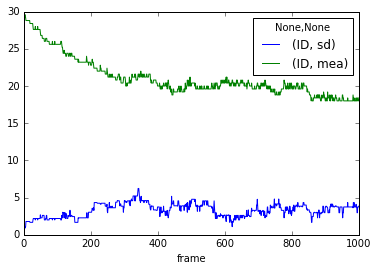

In [20]:
ff = (em1.concentrations())
gg=ff.groupby('type_name')

rr=gg.get_group('mono')
rr=rr.fillna(0).drop('type_name',1)
#rr2 = rr.pivot(index='frame', columns='trj_in', values='ID')
rr3=rr.groupby('frame').agg({'ID':{'mea':'mean', 'sd':'std'}}).rename(index=str).reset_index()
#rr3.index = rr3.index.astype('int')
#rr3.head()
rr4=rr3.set_index(rr3.frame)
rr4.index = rr4.index.astype('int')
rr5=rr4.sort_index()
#rr5.head()
rr5.plot()
plt.show()

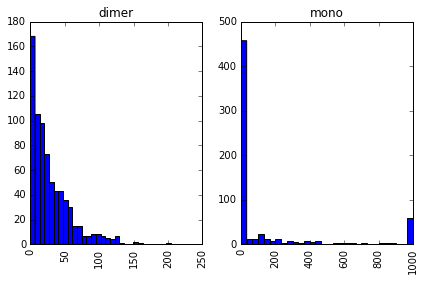

In [21]:
zz=em1.lifetimes(doplot=True);

In [ ]:
col_dict = {'mono':0,'dimer':7}
size_dict = {'mono':2,'dimer':5}
aa = plt_traj2(em1.trajs[0],col_dict, size_dict)
HTML(aa.to_html5_video())